In [280]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Malware classification of PE files
##### Francesco De Marchi

## 0: Objective

Microsoft Portable Executable (PE) files are a common target for malware authors due to their widespread use in Windows operating systems. 
These files, which can be executables, object code, or DLLs, contain metadata within their headers that can provide extensive information about their behavior and potential maliciousness.
Identifying potential threats among these files using header information is a way to speed up static file analysis by reducing the overhead involved in data collection and processing.
This project will explore the effectiveness of different models in discriminating between malicious and benign PE files.

## 1: Data Acquisition

The dataset was taken from a kaggle repository [[1](#reference-section-1)].

The dataset was generated using a python script for PE header analysis [[2](#reference-section-2)].

## 2: Data Exploration

In [281]:
file = open('dataset/ClaMP_Integrated-5184.csv')
df = pd.read_csv(file, skip_blank_lines=True, na_filter=False, encoding='utf-8')

In [282]:
df.isnull().sum()

e_cblp        0
e_cp          0
e_cparhdr     0
e_maxalloc    0
e_sp          0
             ..
E_data        0
filesize      0
E_file        0
fileinfo      0
class         0
Length: 70, dtype: int64

There are no `null` features

### 2.1: Feature explaination

In [283]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5210 entries, 0 to 5209
Data columns (total 70 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   e_cblp                       5210 non-null   int64  
 1   e_cp                         5210 non-null   int64  
 2   e_cparhdr                    5210 non-null   int64  
 3   e_maxalloc                   5210 non-null   int64  
 4   e_sp                         5210 non-null   int64  
 5   e_lfanew                     5210 non-null   int64  
 6   NumberOfSections             5210 non-null   int64  
 7   CreationYear                 5210 non-null   int64  
 8   FH_char0                     5210 non-null   int64  
 9   FH_char1                     5210 non-null   int64  
 10  FH_char2                     5210 non-null   int64  
 11  FH_char3                     5210 non-null   int64  
 12  FH_char4                     5210 non-null   int64  
 13  FH_char5          

The features can be divided in four groups based on the part of the file from which they are derived:    
- Image DOS header:
    - The features whose names are preceded by the lowercase `e` letter
- File header:
    - `NumberOfSections`, `CreationYear` and all of the characteristics flags preceded by `FH`
- Optional header
    - All of the features from `MajorLinkerVersion` to `LoaderFlags`
- Derived features
    - The remaning features are derived from the analyzing the file as a whole
    - The `E` preceding `E_text`,`E_data` and `E_file` stands for entropy

### 2.2: Data Visualization

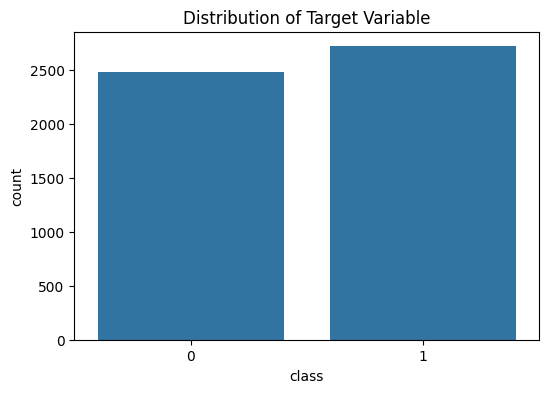

In [284]:
plt.figure(figsize=(6, 4))
sns.countplot(x='class', data=df)
plt.title('Distribution of Target Variable')
plt.show()


The target variable `class`, where 1 indicates that the sample is a malware, is well balanced 

In [285]:
features_to_check = [
    'sus_sections','non_sus_sections','E_file',
    'E_data','E_text','SizeOfImage','SizeOfHeaders',
    'SizeOfInitializedData','SizeOfUninitializedData',
    'SizeOfStackReserve','SizeOfStackCommit',
    'SizeOfHeapReserve','SizeOfHeapCommit'
    ]

We are going to plot only this subset of features using histograms since the others are either binary or pointer addresses

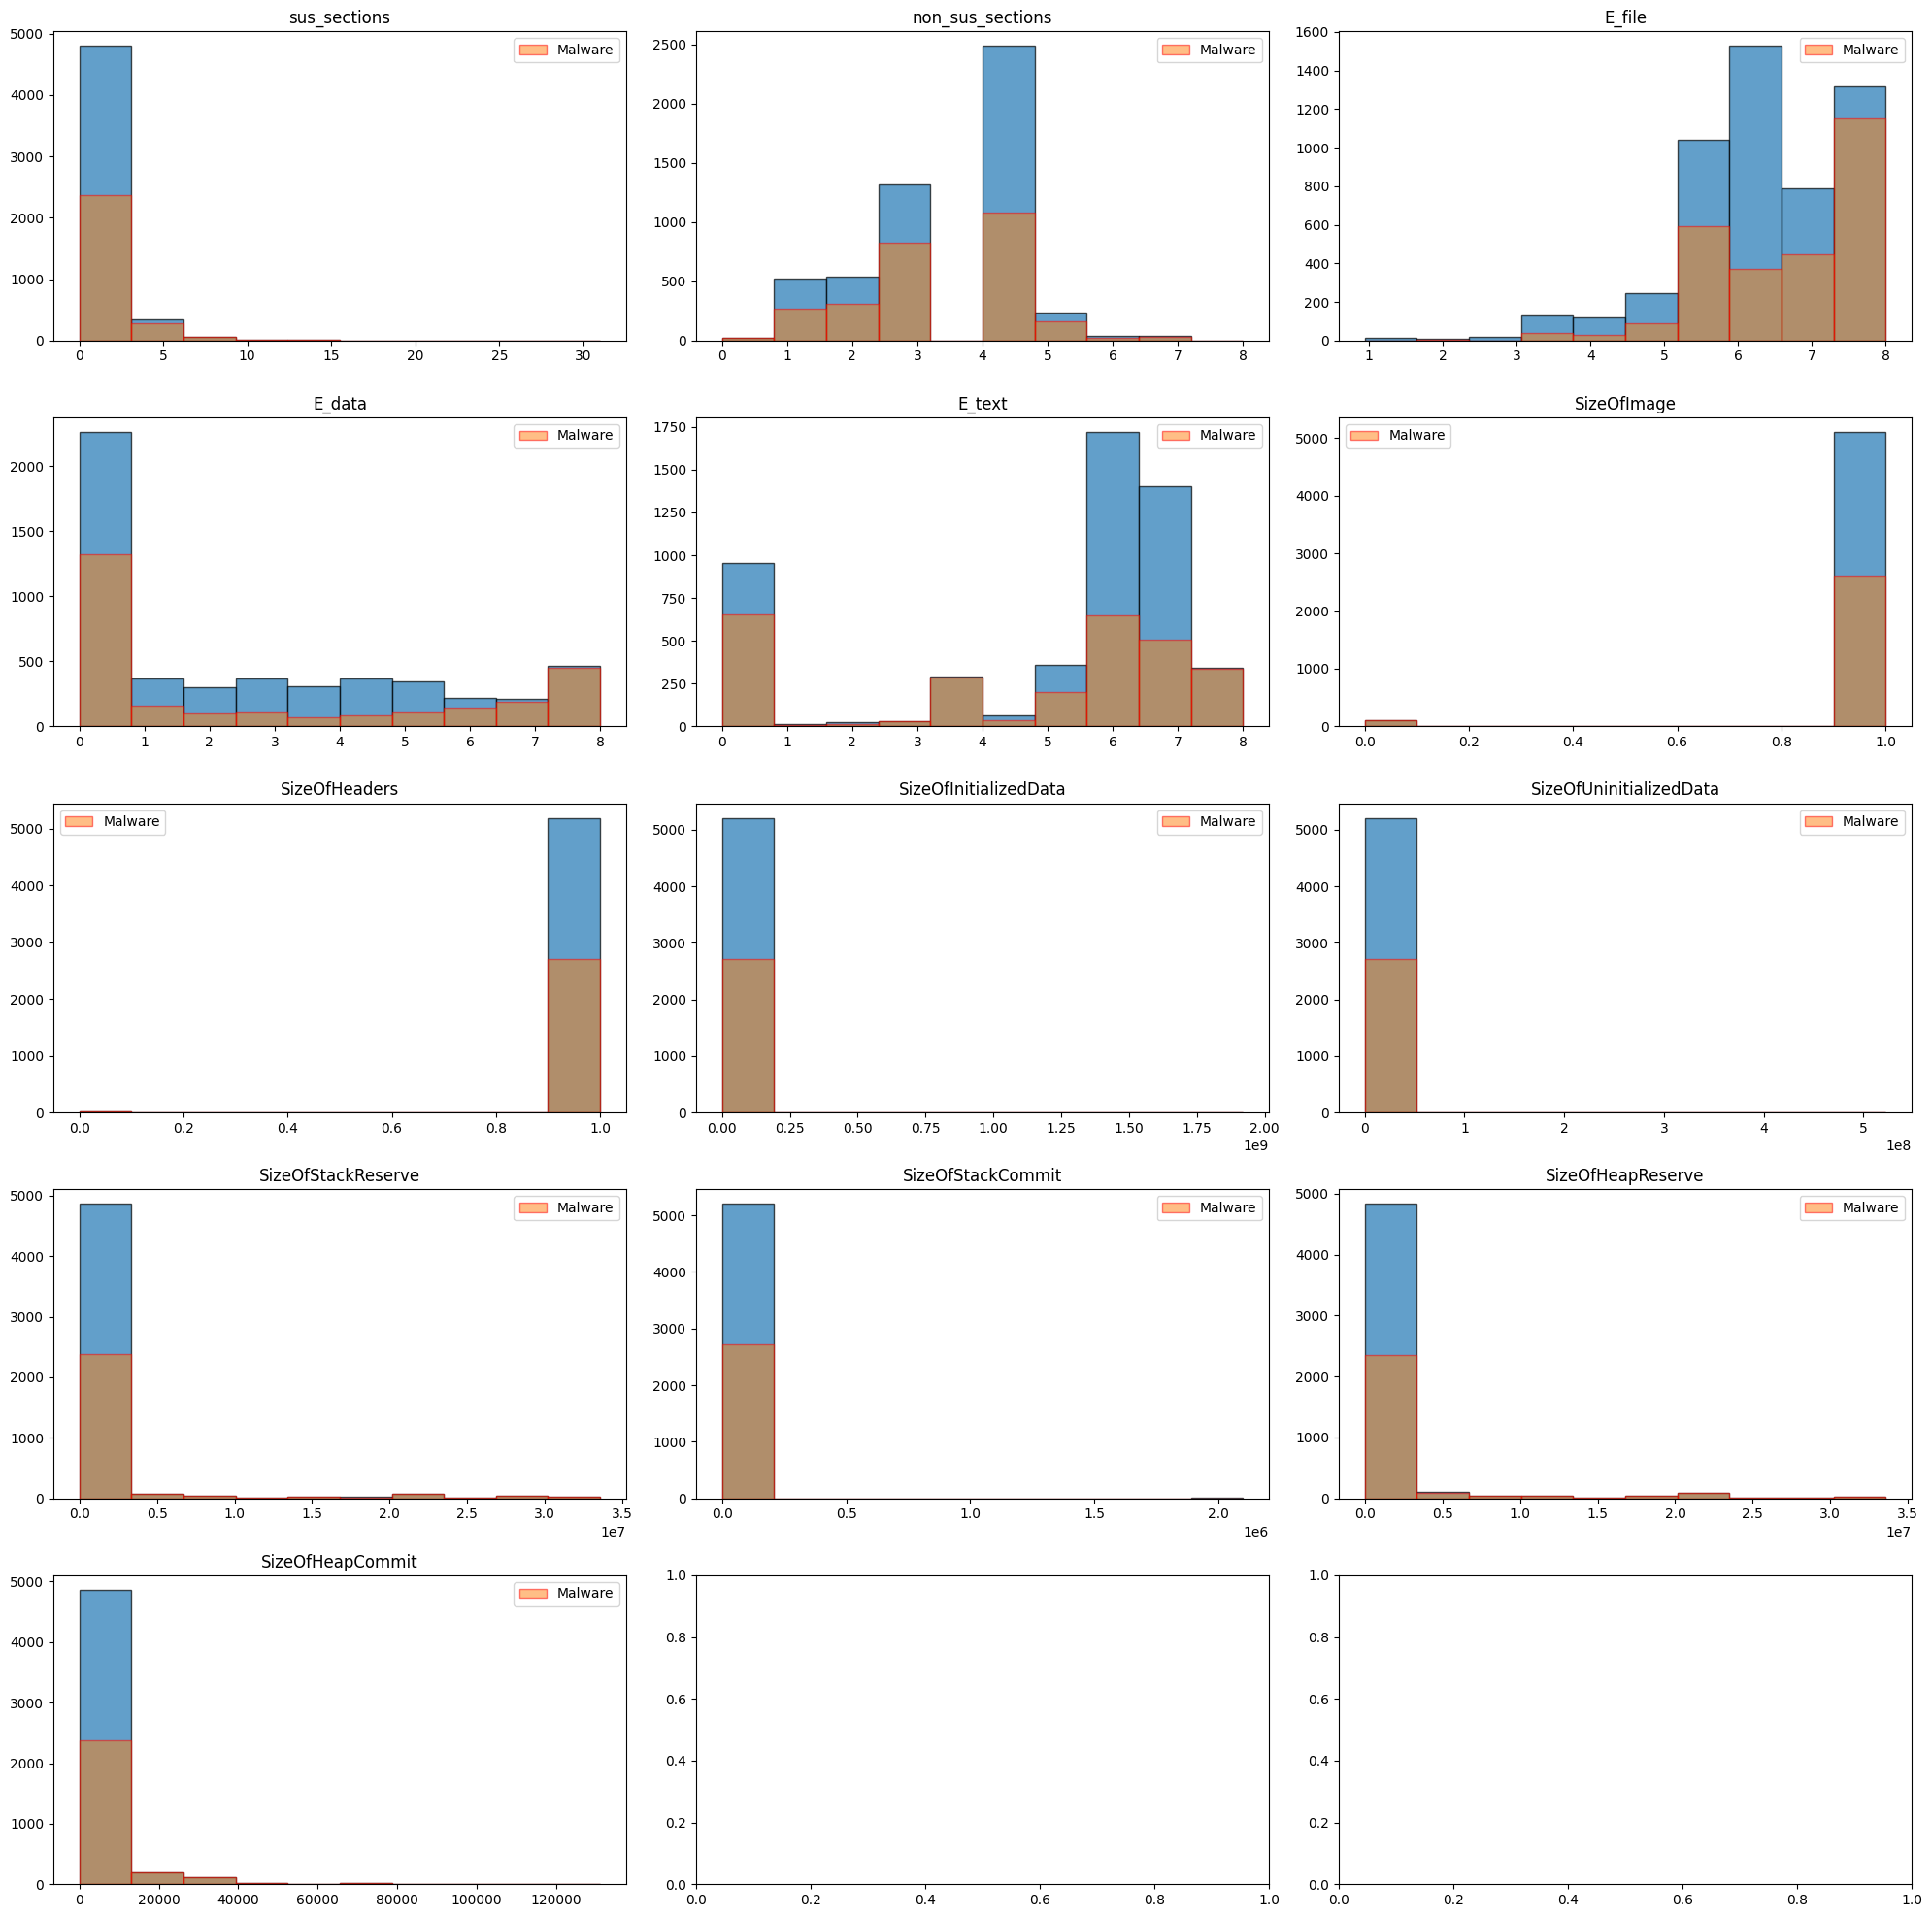

In [286]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(len(features_to_check) // 3 + 1, 3, figsize=(20, 20))
axes = axes.flatten()

for i, feature in enumerate(features_to_check):
    bin_edges = np.histogram_bin_edges(df[feature], bins=10)
    axes[i].hist(df[feature], bins=bin_edges, edgecolor='black', alpha=0.7)
    axes[i].hist(df[df['class'] == 1][feature], bins=bin_edges, edgecolor='red', alpha=0.5, label='Malware')
    axes[i].set_title(feature)
    axes[i].legend()

plt.suptitle('', size=16)
plt.tight_layout(rect=[0, 0, 1, 1])
plt.show()



From the histograms we can notice a few things:
-   The number of `sus_sections` is higher in malware samples
-   The file entropy `E_file` is considerably higher in malware samples
-   While higher entropy is more common in the data and text sections extreme values are strongly correlated with the sample being a malware
-   Bigger sizes of memory reserved for the stack and for the heap are strongly correlated with the sample being a malware

The entropy is higher because malware usually use obfuscation techniques to hinder analysis that increase the apparent randomness of the file. The sus_sections are anomalous section in the executable, meaning the ones that deviate from the standard `.text, .data, .rdata, .idata, .edata, .rsrc, .bss, .crt, .tls`, from this data is apparent that malwares exploit non-standard section naming to deliver or obfuscate the payload.

In [287]:
features_to_check = [
    'sus_sections','non_sus_sections','E_file',
    'E_data','E_text'
    ]

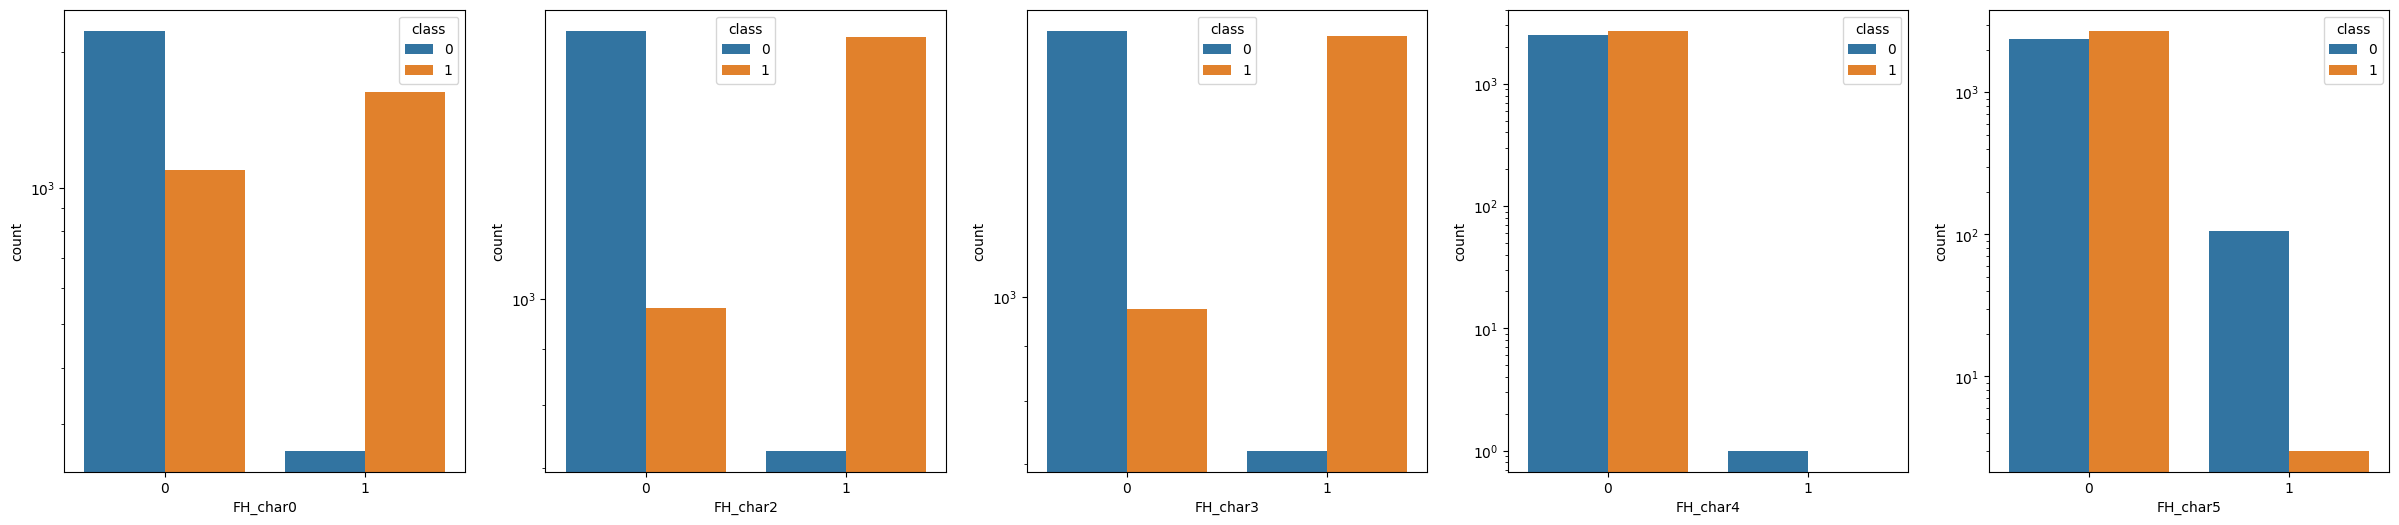

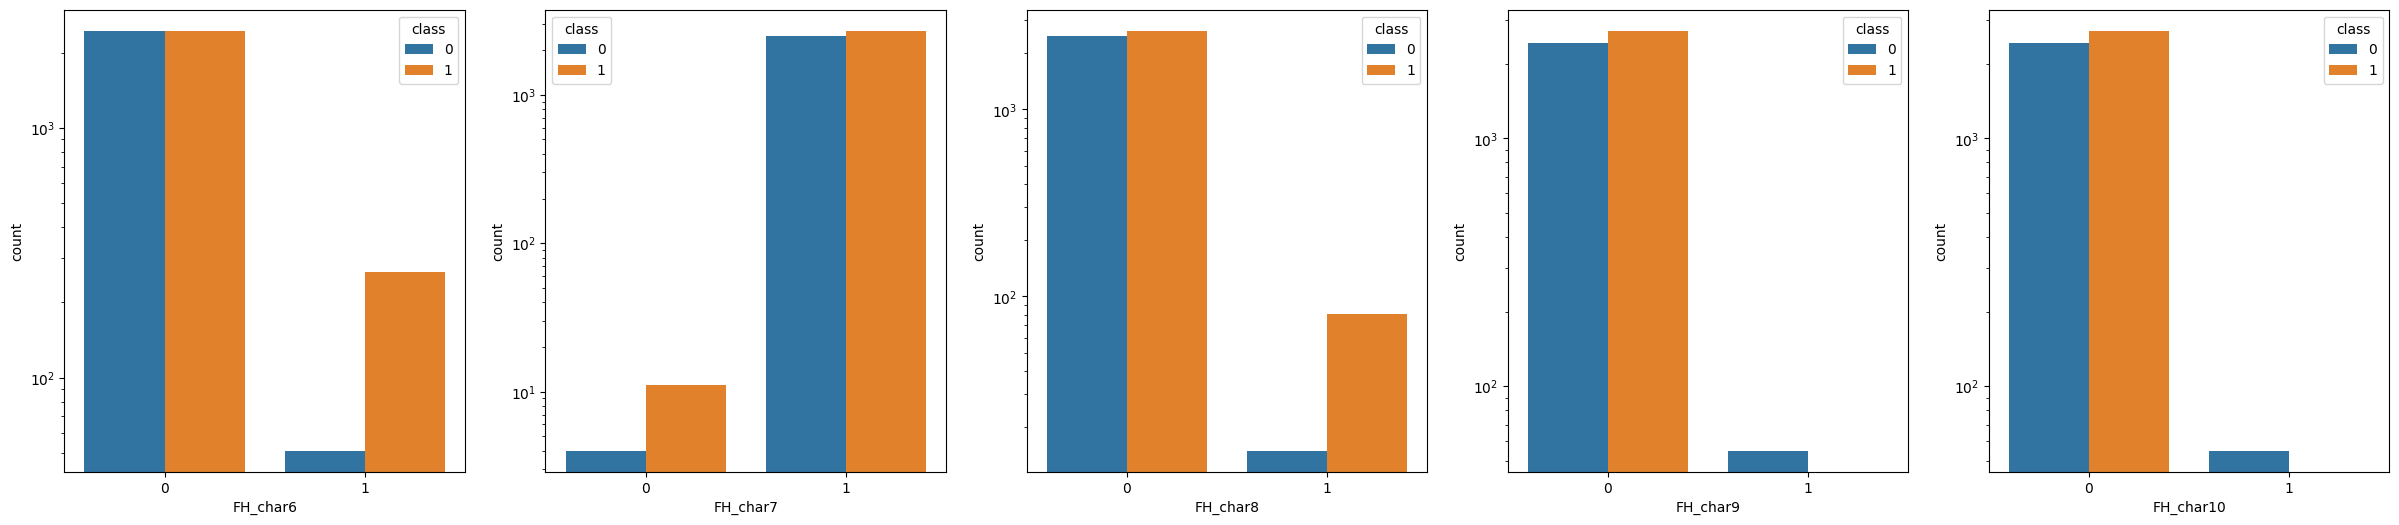

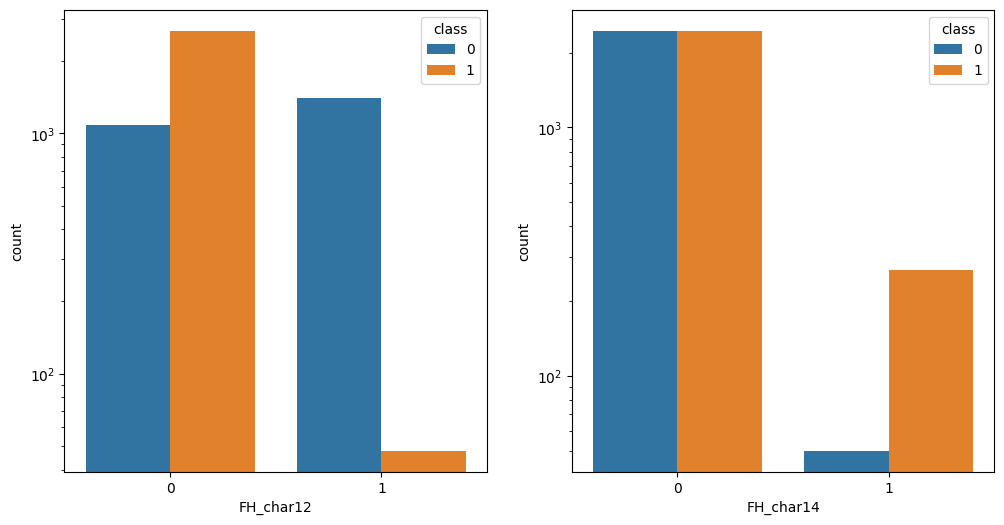

In [288]:
features = [
    'FH_char0', 'FH_char2', 'FH_char3', 
    'FH_char4', 'FH_char5', 'FH_char6', 'FH_char7',
    'FH_char8', 'FH_char9', 'FH_char10',
    'FH_char12', 'FH_char14'
]

nominal_features = df[features]
plots_per_line = 5
for i, column in enumerate(nominal_features.columns):
    if i % plots_per_line == 0:
        r = len(nominal_features.columns) - i
        if r < plots_per_line:
            n_plots = r
        else:
            n_plots = plots_per_line
        _, axs = plt.subplots(1, n_plots, figsize=(6*n_plots, 6))
        plot = 0
    axes = sns.countplot(df, x=column, hue='class', ax=axs[plot])
    axes.set_yscale('log')
    if plot == n_plots-1:
        plt.show()
    plot+=1

By observing these graphs we can notice that only a few of the file header characteristics are relevant to our task (the ones that have constant values have already been excluded):
-   `FHchar0,2,3,8` when set indicate that the file is likely a malware. This is because these flags indicate that symbols have been stripped from these files, another obfuscation technique.
-   `FHchar6,14` when set refer to the endiannes of the program information, this flag is deprecated according to the PE documentation [[5](#reference-section-5)] so the flag being set might indicate that it is being used for other purposes by a malware.
-   `FHchar12` when set indicates that the file is a DLL. DLLs are normally frequent targets of attacks, this is probably due to the dataset containing mostly directly runnalbe malwares.

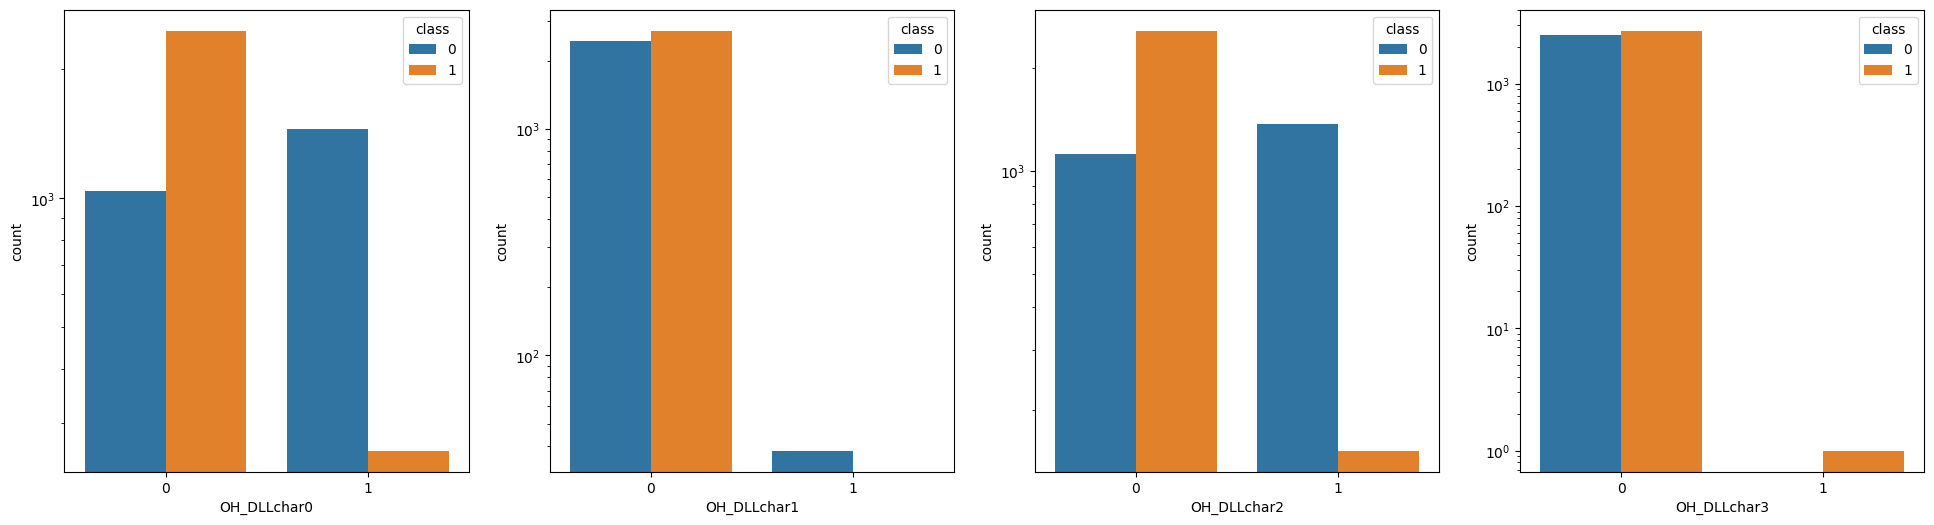

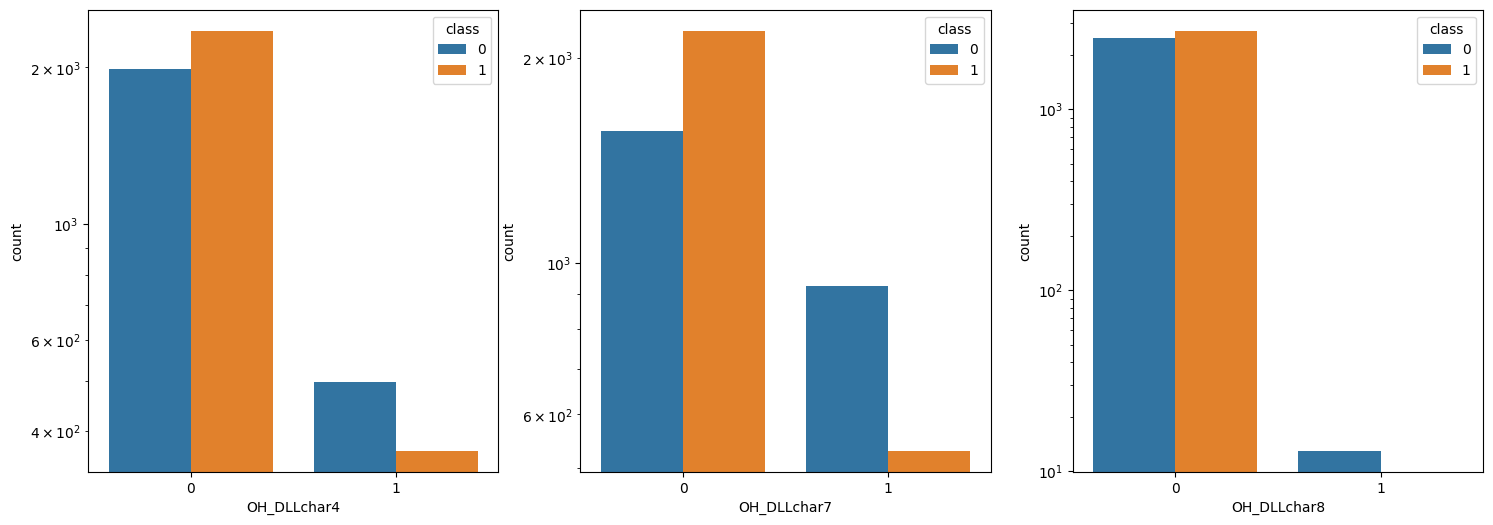

In [289]:
features = [
    'OH_DLLchar0', 'OH_DLLchar1', 'OH_DLLchar2', 'OH_DLLchar3', 
    'OH_DLLchar4', 'OH_DLLchar7',
    'OH_DLLchar8'
]

nominal_features = df[features]
plots_per_line = 4
for i, column in enumerate(nominal_features.columns):
    if i % plots_per_line == 0:
        r = len(nominal_features.columns) - i
        if r < plots_per_line:
            n_plots = r
        else:
            n_plots = plots_per_line
        _, axs = plt.subplots(1, n_plots, figsize=(6*n_plots, 6))
        plot = 0
    axes = sns.countplot(df, x=column, hue='class', ax=axs[plot])
    axes.set_yscale('log')
    if plot == n_plots-1:
        plt.show()
    plot+=1

These graphs refer to DLL characteristics, as we saw earlier malwares are underrepresented in this category of our dataset so most flags being set indicate that the sample is not a malware.

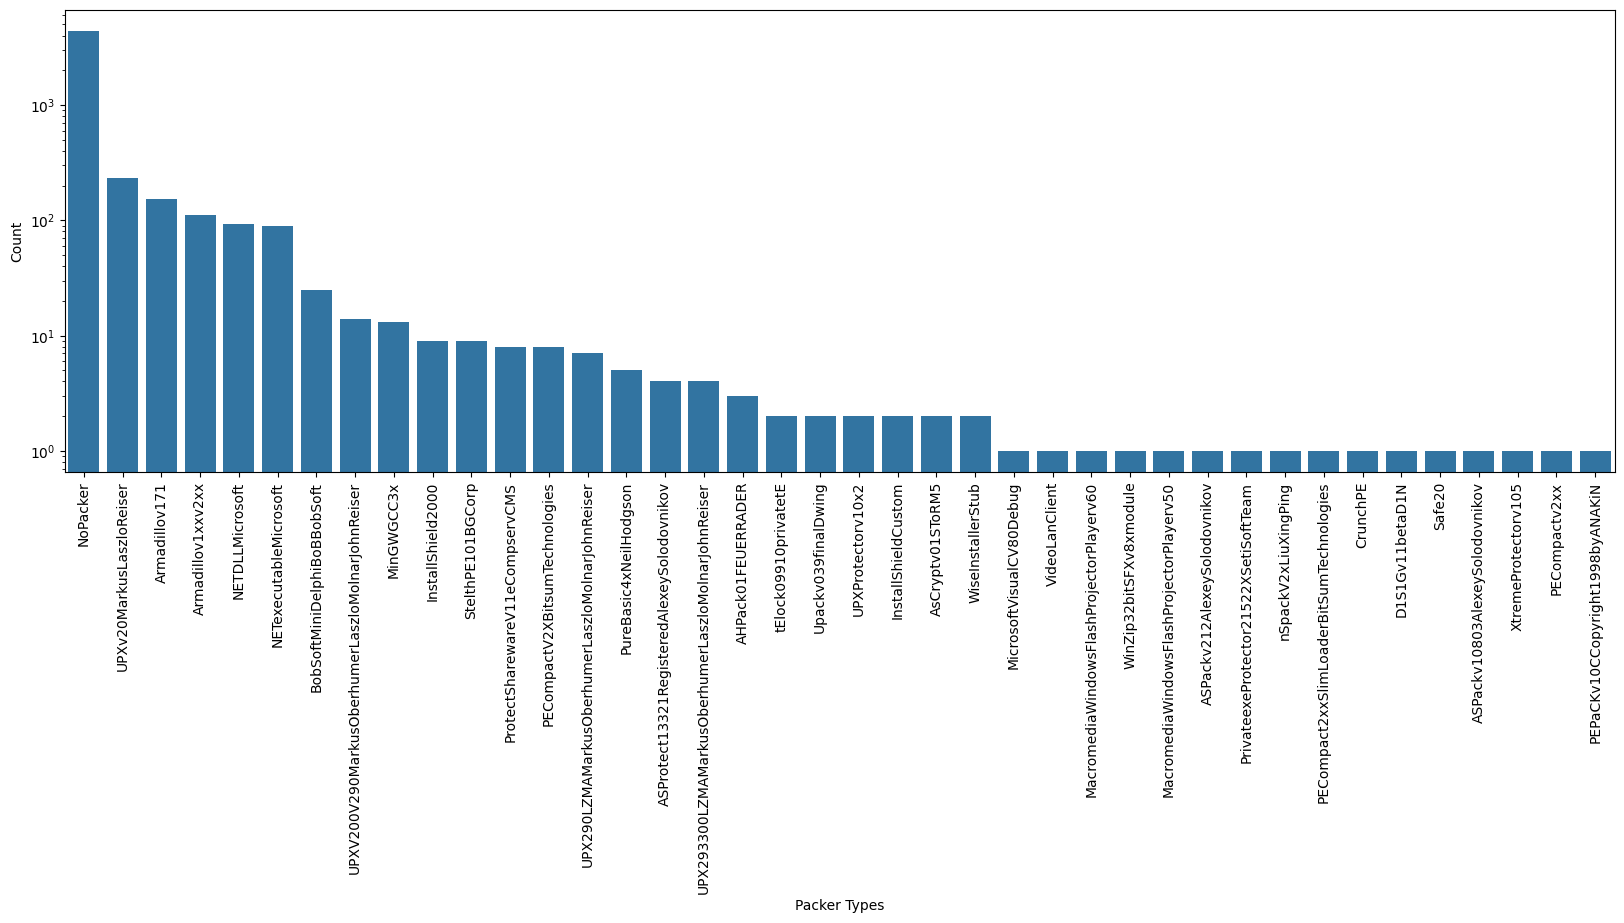

In [290]:
plt.figure(figsize=(20, 6))
axes = sns.countplot(df, x='packer_type', order=df['packer_type'].value_counts().index)
axes.set_yscale('log')
axes.set_xlabel('Packer Types')
axes.set_ylabel('Count')
plt.xticks(rotation='vertical')
plt.show()

Packers are programs used to hide informations regarding an executable and make reverse engineering harder by compressing and encrypting it [[3](#reference-section-3)], the use of packers is correlated with a higher entropy, since we already have measures for entropy in our dataset and a `packer` flag that informs us if a packer was used we can safely discard the `packer_type` column.

If in a malware calssification task specific packer signatures are needed or are surely malicious they can be better identified and handled using YARA rules [[4](#reference-section-4)].

In [291]:
from sklearn.preprocessing import OneHotEncoder

df = df.drop(columns=['packer_type'])
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5210 entries, 0 to 5209
Data columns (total 69 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   e_cblp                       5210 non-null   int64  
 1   e_cp                         5210 non-null   int64  
 2   e_cparhdr                    5210 non-null   int64  
 3   e_maxalloc                   5210 non-null   int64  
 4   e_sp                         5210 non-null   int64  
 5   e_lfanew                     5210 non-null   int64  
 6   NumberOfSections             5210 non-null   int64  
 7   CreationYear                 5210 non-null   int64  
 8   FH_char0                     5210 non-null   int64  
 9   FH_char1                     5210 non-null   int64  
 10  FH_char2                     5210 non-null   int64  
 11  FH_char3                     5210 non-null   int64  
 12  FH_char4                     5210 non-null   int64  
 13  FH_char5          

## 3: Data Preprocessing

In [292]:
from sklearn.model_selection import train_test_split

X = df.drop(['class'], axis=1)
Y = df['class']

train_x, test_x, train_y, test_y = train_test_split(
    X,Y,
    test_size=0.20,  
    random_state=666)

print(train_x.shape)
print(test_x.shape)


(4168, 68)
(1042, 68)


The dataset is split into training and test sets with an 80/20 split

### 2.1: Constant feature elimination


In [293]:

constant_columns = [col for col in train_x.columns if train_x[col].nunique() == 1]

train_x_proc = train_x

train_x_proc.drop(columns=constant_columns)

train_y_proc = train_y

train_x_proc.shape

(4168, 68)

Features with only one value are removed from the training set

### 2.2: Outlier elimination

In [294]:
from sklearn.neighbors import LocalOutlierFactor

LOF = LocalOutlierFactor(n_neighbors = 8)

outliers_lof = LOF.fit_predict(train_x_proc)

train_x_proc.shape

(4168, 68)

The Local Outlier Factor is used to identify outliers in our dataset, this is done since there is no distribution of data to use as a reference.

`n_neighbors` is set to 8 since this removes the least amount of samples from our already small training set.

In [296]:
train_x_proc = train_x_proc[outliers_lof == 1]
train_y_proc = train_y[outliers_lof == 1]


print(train_x_proc.shape)
train_y_proc.shape

(3569, 68)


(3569,)

In [298]:
constant_columns = [col for col in train_x_proc.columns if train_x_proc[col].nunique() == 1]

train_x_proc = train_x_proc.drop(columns=constant_columns)

train_x_proc.shape

(3569, 56)

In [300]:
constant_columns

['FH_char1',
 'FH_char4',
 'FH_char11',
 'FH_char13',
 'SectionAlignment',
 'FileAlignment',
 'OH_DLLchar3',
 'OH_DLLchar5',
 'OH_DLLchar6',
 'OH_DLLchar9',
 'OH_DLLchar10',
 'LoaderFlags']

The training set is once again checked for constant features, if they are found they are dropped

### 2.3: Correlation Analysis

In [301]:
train_full = pd.concat([train_x_proc, train_y_proc], axis=1)

train_full.shape

(3569, 57)

In [302]:
corr_matrix = train_full.corr(method='pearson').round(2)

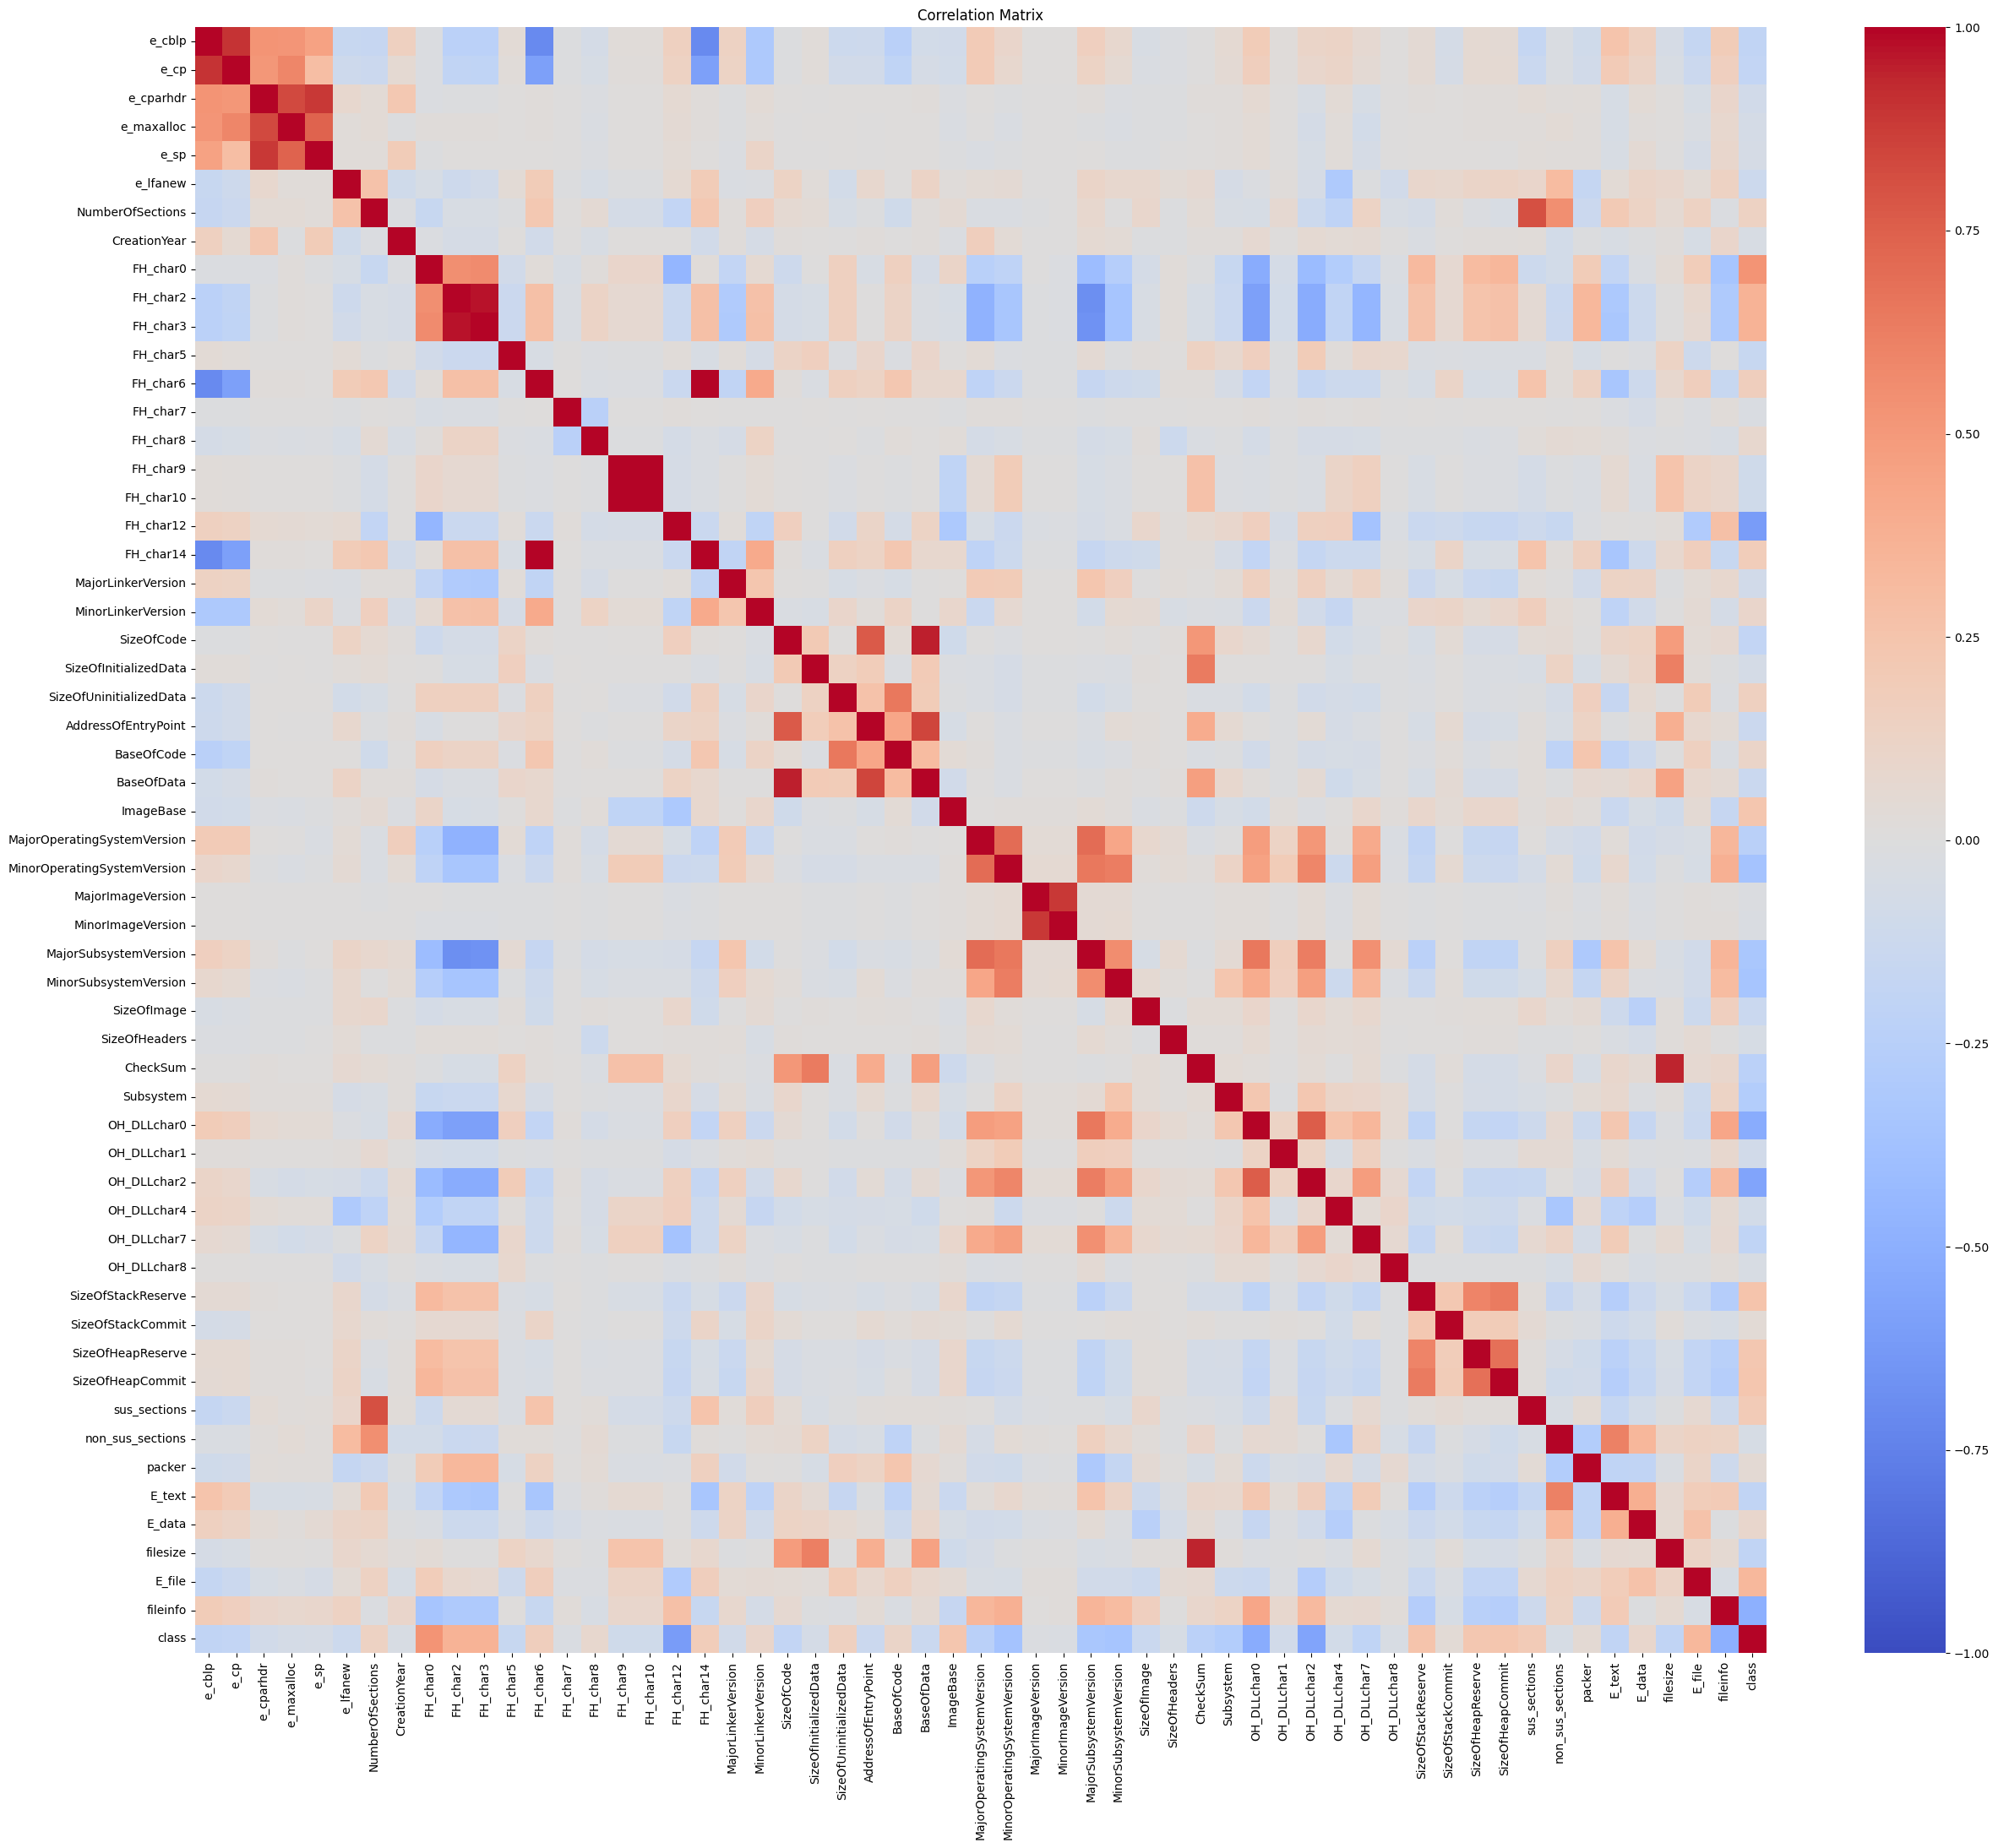

In [303]:
plt.figure(figsize=(30, 25))
sns.heatmap(corr_matrix, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.show()

As we can see for the heatmap many features are strongly correlated with eachother. File sizes also affect the data a lot, as is apparent when looking at the correlation of features that deal with addresses and memory size.

We can also notice that a lot of the features have a very weak correlation with the target variable.

In [304]:
correlation_with_class = corr_matrix['class'].abs()
selected_features = correlation_with_class[correlation_with_class >= 0.1].index

train_full_filtered = train_full[selected_features]

The features with a very weak correlation to the target variable are dropped since their absence will not significantly impact classification performance and will make the task easier and less computationally intensive.

### 2.4: Feature Selection

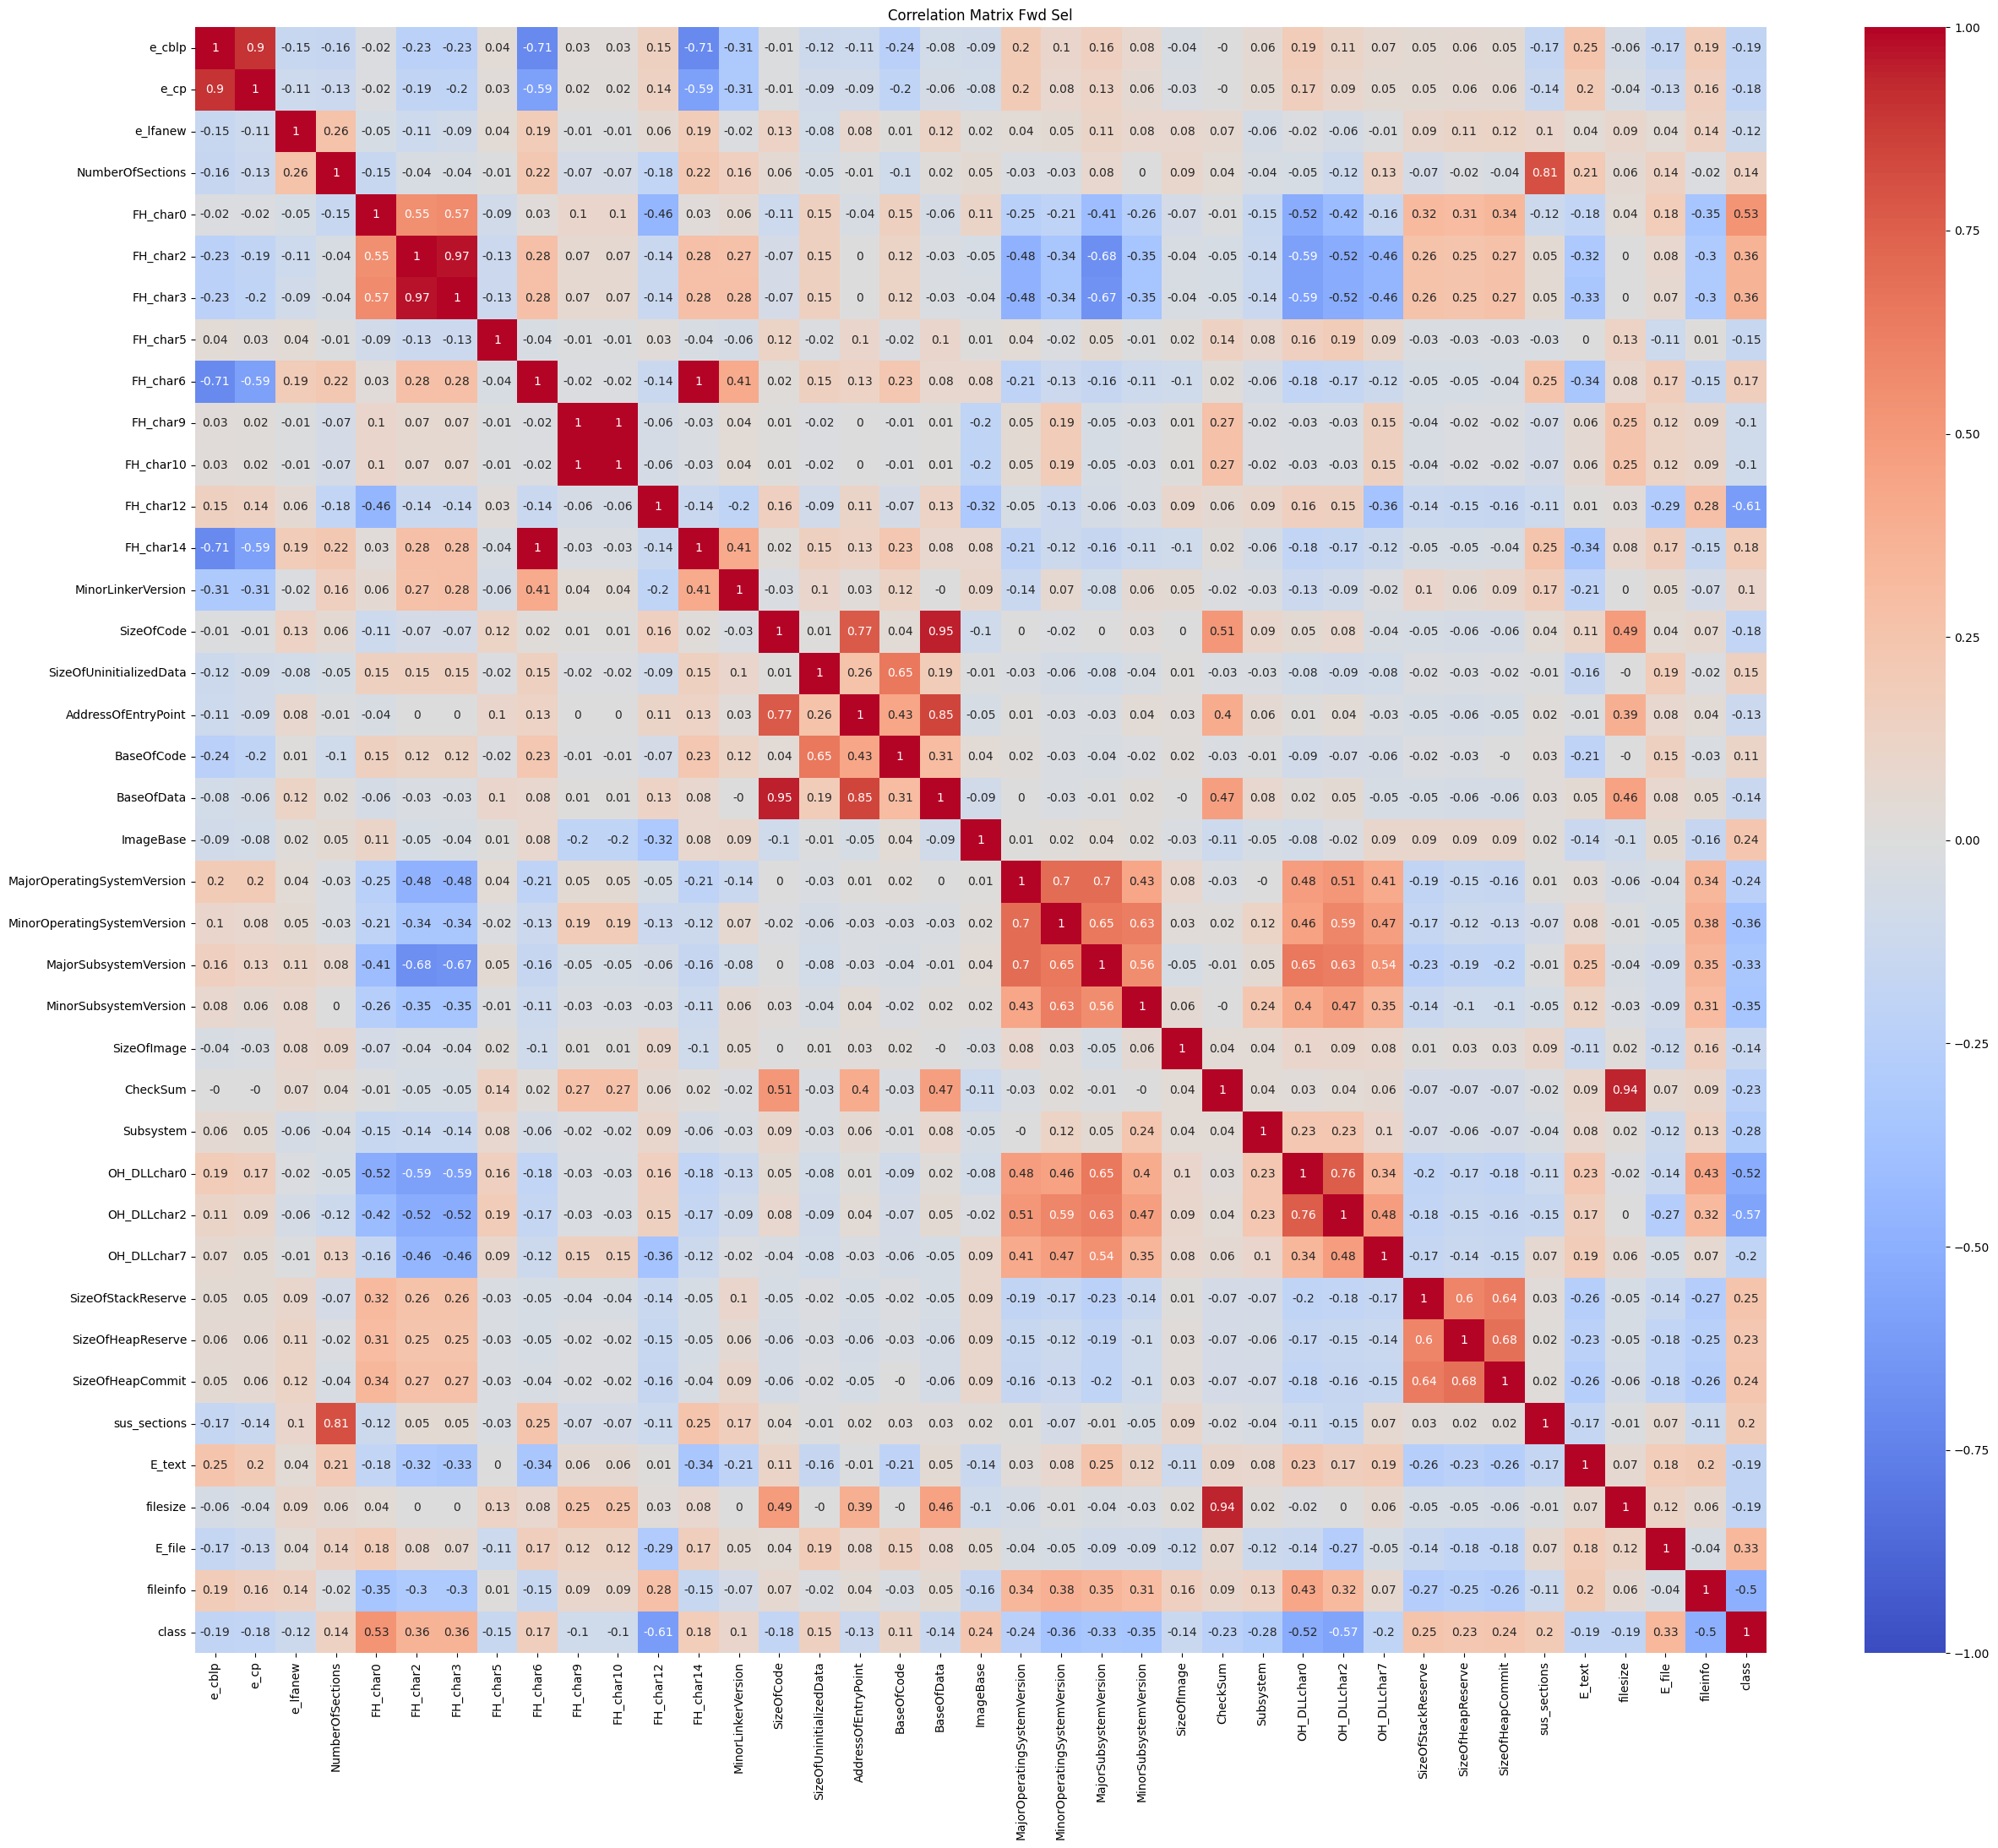

In [305]:
corr_matrix = train_full_filtered.corr(method='pearson').round(2)

plt.figure(figsize=(30,25))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.show()

From this correlation matrix of the remaining features it is apparent that there is still a sizeable number of higly correlated features.
Using chi-squared as a metric we will decide which ones will be dropped.

In [306]:
train_x_filtered = train_full_filtered.drop(columns=['class'])

In [ ]:
t_x_fil_first_pass = train_x_filtered

In [307]:
from scipy.stats import chi2_contingency

def compute_chi2(candidates):
    for c in candidates:
        contingency_table = pd.crosstab(train_full_filtered[c], train_full_filtered['class'])
        chi2, p, dof, expected = chi2_contingency(contingency_table)
        print(f"Feature {c}: Chi-Square={chi2}, P-Value={p}, Degrees-Of-Freedom={dof}")

to_remove = []

#### Correlated features: e_cblp, e_cp


In [308]:
candidates = ['e_cblp', 'e_cp']
compute_chi2(candidates)

Feature e_cblp: Chi-Square=142.22067094067557, P-Value=3.4058243564942565e-28, Degrees-Of-Freedom=6
Feature e_cp: Chi-Square=139.27767785843298, P-Value=4.029768327454232e-29, Degrees-Of-Freedom=4


Both of these features are realtively weakly correlated with the target feature and will be dropped

In [309]:
to_remove += candidates

to_remove

['e_cblp', 'e_cp']

#### Correlated features: FH_char0, FH_char2, FH_char3


In [310]:

candidates = ['FH_char0', 'FH_char2', 'FH_char3']
compute_chi2(candidates)


Feature FH_char0: Chi-Square=988.34662135202, P-Value=6.127808445866876e-217, Degrees-Of-Freedom=1
Feature FH_char2: Chi-Square=458.03263489919755, P-Value=1.2883262705877344e-101, Degrees-Of-Freedom=1
Feature FH_char3: Chi-Square=460.9162733231265, P-Value=3.0373496822618465e-102, Degrees-Of-Freedom=1


These three values correpsond to different file header flags:
- `FH_char0` -> `IMAGE_FILE_RELOCS_STRIPPED`
    - The file does not contain base relocations and must therefore be loaded at its preferred base address
- `FH_char2` -> `IMAGE_FILE_LINE_NUMS_STRIPPED`
    - COFF line numbers have been removed
- `FH_char3` -> `IMAGE_FILE_LOCAL_SYMS_STRIPPED`
    - COFF symbol table entries for local symbols have been removed

As we can see from the Chi-Square values the two values `FH_char2` and `FH_char3` are relatively weakly related with the target variable when compared with the `FH_char0` feature.
This is understandable since they both refer to the fact that the debug symbols have been stripped from the executable, a practice common to both malicious and non-malicious software.

These two features will thus be removed.

In [311]:
to_remove += ['FH_char3']

to_remove

['e_cblp', 'e_cp', 'FH_char3']

#### Correlated features: FH_char6, FH_char14


In [312]:
candidates = ['FH_char6','FH_char14']
compute_chi2(candidates)

Feature FH_char6: Chi-Square=106.9351436629996, P-Value=4.599789678383846e-25, Degrees-Of-Freedom=1
Feature FH_char14: Chi-Square=107.91282275025614, P-Value=2.808643067310675e-25, Degrees-Of-Freedom=1


These two values correpsond to different file header flags:
- `FH_char6` -> `IMAGE_FILE_BYTES_REVERSED_LO `
    - Little endian
- `FH_char14` -> `IMAGE_FILE_BYTES_REVERSED_HI `
    - Big endian

Both of these values are very similar since the flags have an extremely similar function, they are both realtively weakly related with the target variable and will be dropped

In [313]:
to_remove += ['FH_char6','FH_char14']

#### Correlated features: FH_char9, FH_char10


In [314]:
candidates = ['FH_char9', 'FH_char10']
compute_chi2(candidates)

Feature FH_char9: Chi-Square=34.11439822383116, P-Value=5.19653322813952e-09, Degrees-Of-Freedom=1
Feature FH_char10: Chi-Square=34.11439822383116, P-Value=5.19653322813952e-09, Degrees-Of-Freedom=1


- `FH_char9` -> `IMAGE_FILE_REMOVABLE_RUN_ FROM_SWAP  `
    - If the image is on removable media, fully load it and copy it to the swap file. 
- `FH_char10` -> `IMAGE_FILE_NET_RUN_FROM_SWAP  `
    - If the image is on network media, fully load it and copy it to the swap file. 

Both of these features have relatively low chi-square values and relatively high p-values, they will both be dropped.

In [315]:
to_remove += candidates

#### Correlated features: AddressOfEntryPoint, SizeOfCode, BaseOfData


In [316]:
candidates = ['AddressOfEntryPoint','SizeOfCode', 'BaseOfData']
compute_chi2(candidates)

Feature AddressOfEntryPoint: Chi-Square=3433.87313020737, P-Value=9.842812928132922e-38, Degrees-Of-Freedom=2431
Feature SizeOfCode: Chi-Square=1291.5372220226475, P-Value=1.9572367042982222e-32, Degrees-Of-Freedom=741
Feature BaseOfData: Chi-Square=775.2159565779043, P-Value=2.5418437187231337e-41, Degrees-Of-Freedom=312


- `AddressOfEntryPoint`
    - The address of the entry point of the program
- `SizeOfCode`
    - Total size of the program code
- `BaseOfData`
    - The base address of the data section

All of these values are strongly correlated with the target variable, however `SizeOfCode` will be prioritized over the correlated variable `BaseOfData`due to the chi-square value

In [317]:
to_remove += ['BaseOfData']

#### Correlated features: MajorOperatingSystemVersion, MinorOperatingSystemVersion, MajorSubsystemVersion, MinorSubsystemVersion, OH_DLLchar0, OH_DLLchar2, OH_DLLchar7


In [318]:
candidates = ['MajorOperatingSystemVersion', 'MinorOperatingSystemVersion','MajorSubsystemVersion','MinorSubsystemVersion','OH_DLLchar0','OH_DLLchar2','OH_DLLchar7']
compute_chi2(candidates)

Feature MajorOperatingSystemVersion: Chi-Square=771.3356287621762, P-Value=3.137963859297427e-160, Degrees-Of-Freedom=9
Feature MinorOperatingSystemVersion: Chi-Square=657.8488617312544, P-Value=4.659605916994576e-141, Degrees-Of-Freedom=4
Feature MajorSubsystemVersion: Chi-Square=666.1219626812332, P-Value=4.6539436128908766e-144, Degrees-Of-Freedom=3
Feature MinorSubsystemVersion: Chi-Square=619.0691562690239, P-Value=1.1559810745588882e-132, Degrees-Of-Freedom=4
Feature OH_DLLchar0: Chi-Square=953.8198491377756, P-Value=1.9606683772817428e-209, Degrees-Of-Freedom=1
Feature OH_DLLchar2: Chi-Square=1153.4913941596014, P-Value=7.817780762391349e-253, Degrees-Of-Freedom=1
Feature OH_DLLchar7: Chi-Square=141.15223274008736, P-Value=1.4902330506009487e-32, Degrees-Of-Freedom=1


- `OH_DLLchar0` -> `IMAGE_DLLCHARACTERISTICS_HIGH_ENTROPY_VA `
    - Image can handle a high entropy 64-bit virtual address space.  
- `OH_DLLchar2` -> `IMAGE_DLLCHARACTERISTICS_FORCE_INTEGRITY`
    - Code Integrity checks are enforced. 
- `OH_DLLchar7` -> `IMAGE_DLLCHARACTERISTICS_APPCONTAINER `
    - Image must execute in an AppContainer.

`OH_DLLchar7` appears to be relatively weakly related with the target variable, `MinorSubsystemVersion` and `MinorOperatingSystemVersion` will also be dropped to prioritize the correlated features with higher chi-square values.

In [319]:
to_remove += ['OH_DLLchar7','MinorSubsystemVersion','MinorOperatingSystemVersion']

#### Correlated features: SizeOfStackReserve, SizeOfHeapReserve, SizeOfHeapCommit

In [320]:
candidates = ['SizeOfStackReserve', 'SizeOfHeapReserve','SizeOfHeapCommit']
compute_chi2(candidates)

Feature SizeOfStackReserve: Chi-Square=981.7849025870603, P-Value=6.571025439880723e-192, Degrees-Of-Freedom=24
Feature SizeOfHeapReserve: Chi-Square=316.9905902967346, P-Value=2.9435094368493066e-51, Degrees-Of-Freedom=27
Feature SizeOfHeapCommit: Chi-Square=270.95521844237715, P-Value=1.1270087851836239e-51, Degrees-Of-Freedom=11


Due to the considerably higher chi-square value only `SizeOfStackReserve` will be kept

In [321]:
to_remove += ['SizeOfHeapReserve','SizeOfHeapCommit']

#### Correlated features: filesize, CheckSum

In [322]:
candidates = ['filesize', 'CheckSum']
compute_chi2(candidates)

Feature filesize: Chi-Square=2602.2453467415658, P-Value=1.5151961687460774e-35, Degrees-Of-Freedom=1762
Feature CheckSum: Chi-Square=3086.85966960963, P-Value=1.238790928631595e-22, Degrees-Of-Freedom=2356


While these two features are related, removing either of them degrades the performance of the model.
This could be due to the model being very reliant on file size to determine the class of an example, this could be fixed by increasing the number of malwares with a small file size in the dataset.

#### Correlated features: sus_sections, NumberOfSections

In [323]:
candidates = ['sus_sections', 'NumberOfSections']
compute_chi2(candidates)

Feature sus_sections: Chi-Square=1038.919801474089, P-Value=2.595146646558952e-208, Degrees-Of-Freedom=19
Feature NumberOfSections: Chi-Square=620.7554416050314, P-Value=1.2152259337564617e-118, Degrees-Of-Freedom=20


Because of the lower score `NumberOfSections` will be dropped

In [324]:
to_remove += ['NumberOfSections']

In [325]:
to_remove

['e_cblp',
 'e_cp',
 'FH_char3',
 'FH_char6',
 'FH_char14',
 'FH_char9',
 'FH_char10',
 'BaseOfData',
 'OH_DLLchar7',
 'MinorSubsystemVersion',
 'MinorOperatingSystemVersion',
 'SizeOfHeapReserve',
 'SizeOfHeapCommit',
 'NumberOfSections']

In [326]:
train_x_filtered = train_x_filtered.drop(columns=to_remove)
train_x_filtered.shape

(3569, 24)

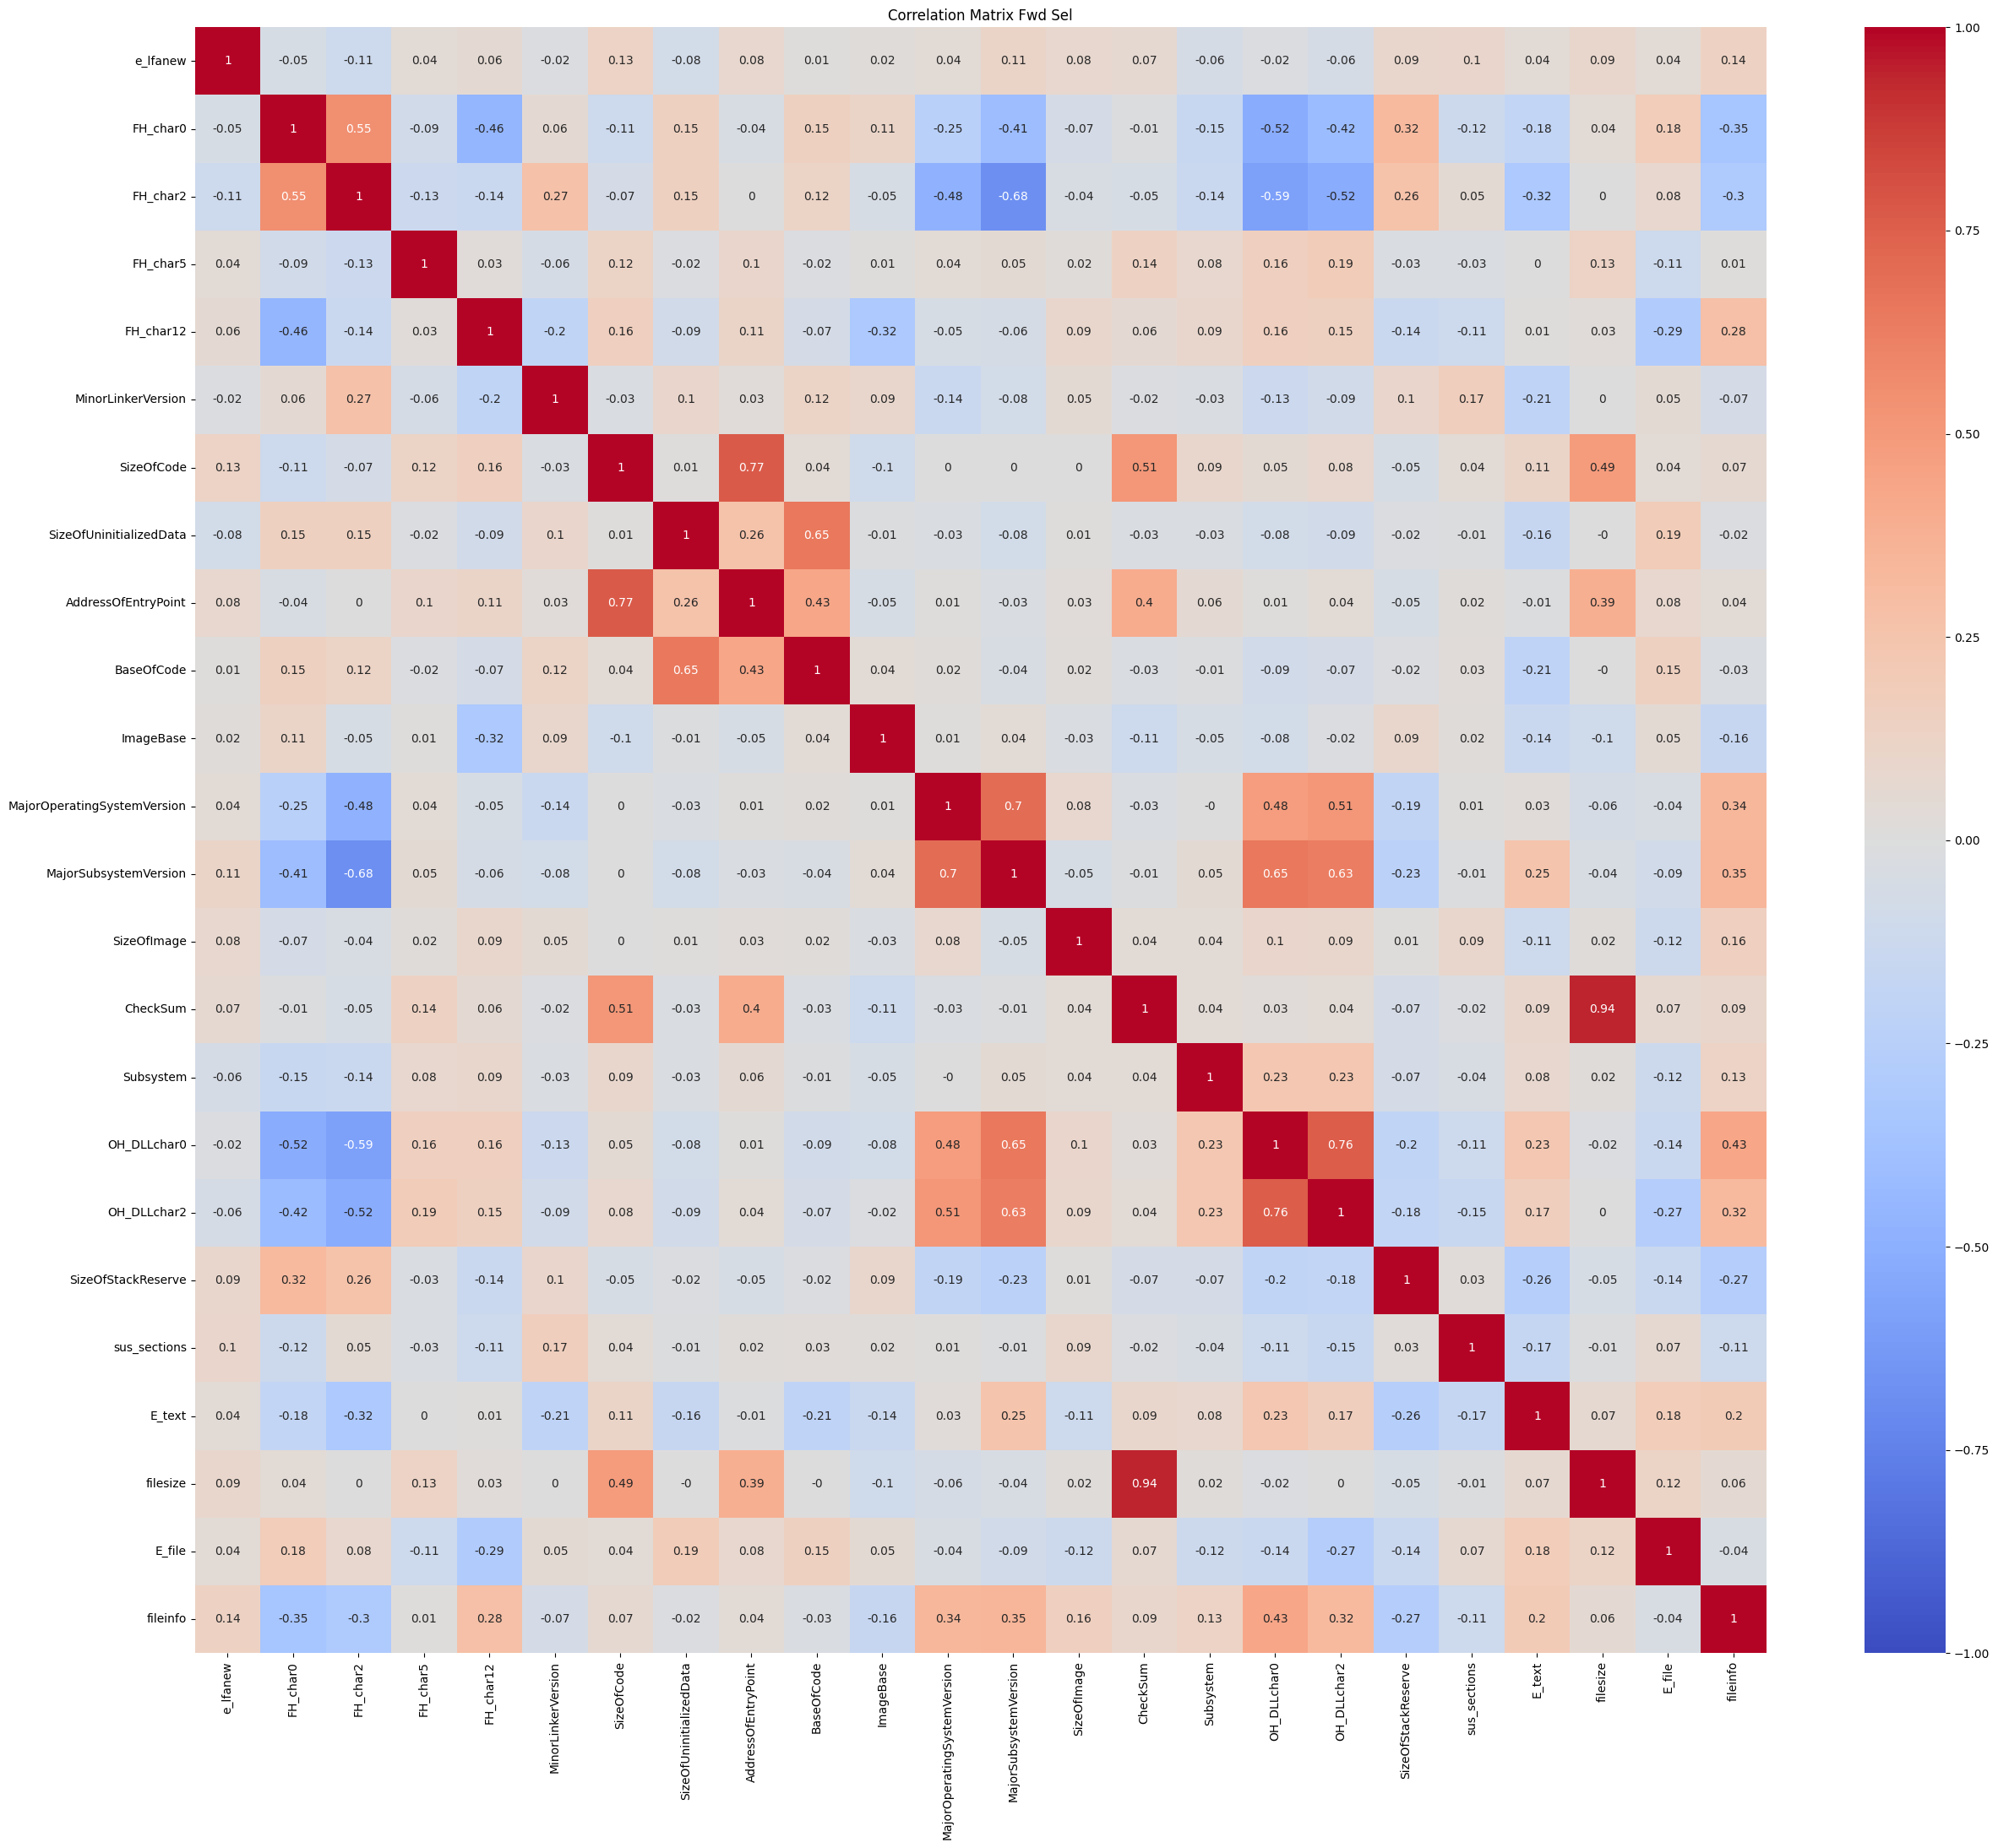

In [327]:
corr_matrix = train_x_filtered.corr(method='pearson').round(2)

plt.figure(figsize=(30,25))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.show()

## 4: Processing

### 4.1: Feature Scaling

In [328]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

train_x_scaled = scaler.fit_transform(train_x_filtered)

train_x_scaled = pd.DataFrame(train_x_scaled, columns=train_x_filtered.columns)

test_filtered_x = test_x[train_x_filtered.columns]

test_x_scaled = scaler.transform(test_filtered_x)


The features are scaled using z-score normalization to prepare the data for processing

In [329]:
import pickle

with open('scaler.pkl','wb') as f:
    pickle.dump(scaler,f)

The scaler is exported for later use

### 4.2: Support Vector Machine Classification

In [330]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

svm = SVC()

param_grid = {
    'C': [0.1, 1, 10, 100, 1000, 10000],
    'gamma': [1, 0.1, 0.01, 0.001],
    'kernel': ['rbf']
}

grid_search = GridSearchCV(svm, param_grid, cv=5, scoring='accuracy')
grid_search.fit(train_x_scaled, train_y_proc)

results = pd.DataFrame(grid_search.cv_results_)

best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f"Best Parameters: {best_params}")
print(f"Best CV Score: {best_score:.4f}")

Best Parameters: {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}
Best CV Score: 0.9849


To finetune the hyperparamters of the SVM we perform a grid search on the two kernel parameters `C` and `gamma`.
`C` is responsible for smoothing the decision boundary, a low value wil pursue a smooth boundary at the cost of misclasffication.
`gamma` defines the influence of a single training sample on the boundary, the higher the gamma the closer the samples have to be to the boundary for it to be affected. [[6](#reference-section-6)]

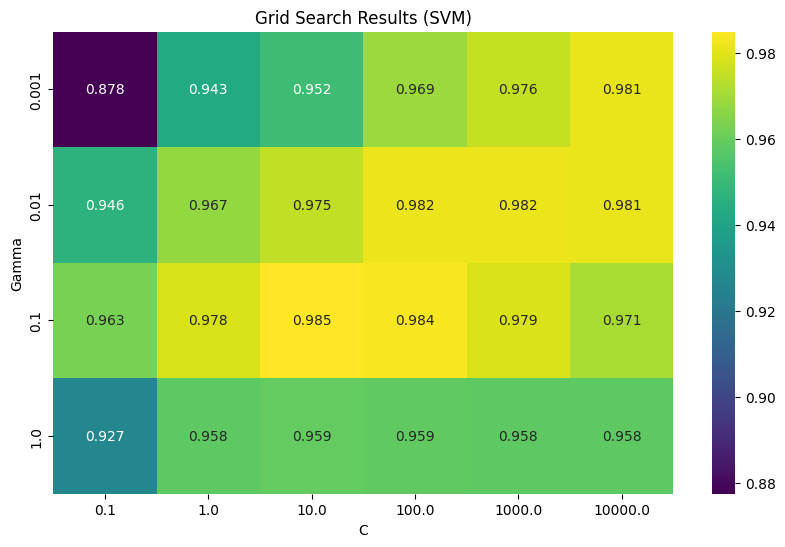

In [331]:
C_values = results['param_C'].astype(float)
gamma_values = results['param_gamma'].astype(float)
mean_test_scores = results['mean_test_score']

heatmap_data = pd.pivot_table(
    results,
    values='mean_test_score',
    index='param_gamma',
    columns='param_C'
)

plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, annot=True, fmt=".3f", cmap='viridis')
plt.title('Grid Search Results (SVM)')
plt.xlabel('C')
plt.ylabel('Gamma')
plt.show()

With a smoother boundary gamma becomes a crucial parameter for the accuracy of the classification, as `C` increases the effect of gamma is greatly reduced making accuracy gains more marginal

In [332]:
svm_classifier = SVC(kernel=best_params['kernel'], C=best_params['C'], gamma=best_params['gamma'],random_state=573)

svm_classifier.fit(train_x_scaled, train_y_proc)

SVC(C=10, gamma=0.1, random_state=573)

### 4.3: Neural Network Classification

In [333]:
from sklearn.neural_network import MLPClassifier

from sklearn.model_selection import GridSearchCV

param_grid = {
    'hidden_layer_sizes' : [(25,),(50,),(75,),(100,), (25,25),(50,25),(100,50),(100,50,25),(100,50,50,25)]
}

mlp = MLPClassifier(max_iter=750, activation='relu')

grid_search = GridSearchCV(mlp, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(train_x_scaled, train_y_proc)

results = pd.DataFrame(grid_search.cv_results_)

best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f"Best Parameters: {best_params}")
print(f"Best CV Score: {best_score:.4f}")

Best Parameters: {'hidden_layer_sizes': (50,)}
Best CV Score: 0.9866


To finetune the hyperparamters of the NN we perform a grid search on the size of the hidden layers.
The sizes were chosen using an approximation of the total number of features as a starting point.

/tmp/ipykernel_6515/1185054794.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Hidden Layer Sizes', y='Mean Test Score', data=plot_data, palette="viridis")


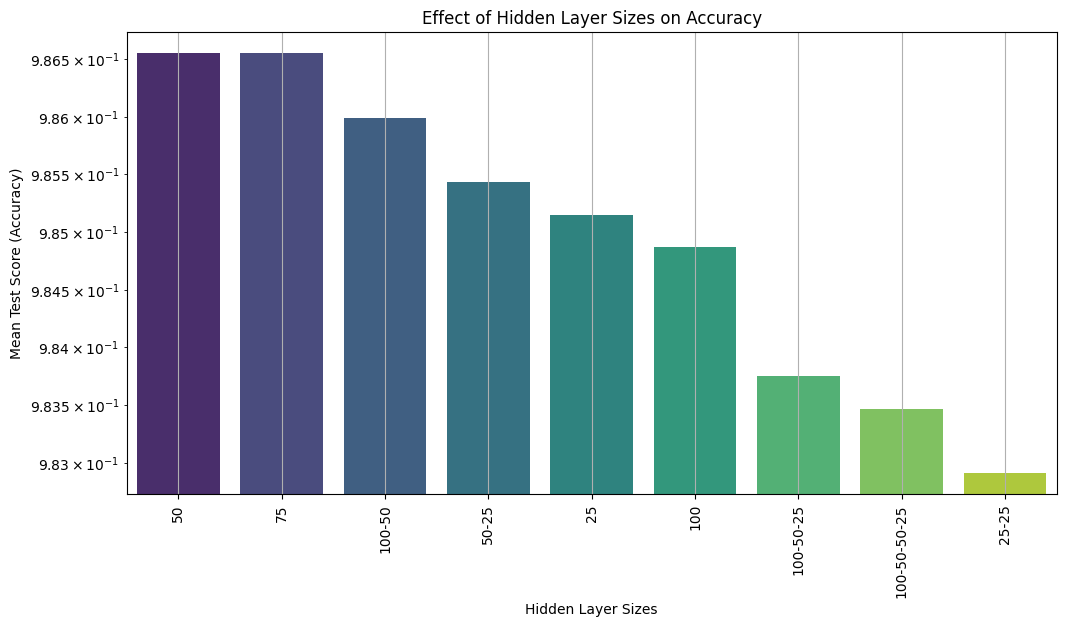

In [334]:
hidden_layer_sizes = ['-'.join(map(str, size)) for size in results['param_hidden_layer_sizes']]
mean_test_scores = results['mean_test_score']

plot_data = pd.DataFrame({
    'Hidden Layer Sizes': hidden_layer_sizes,
    'Mean Test Score': mean_test_scores
})

plot_data = plot_data.sort_values('Mean Test Score', ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x='Hidden Layer Sizes', y='Mean Test Score', data=plot_data, palette="viridis")

plt.yscale('log')
plt.xlabel('Hidden Layer Sizes')
plt.ylabel('Mean Test Score (Accuracy)')
plt.title('Effect of Hidden Layer Sizes on Accuracy')
plt.xticks(rotation='vertical')
plt.grid(True)
plt.show()

The effect of this fine tuning is marginal and this step could be skipped and a one hidden layer model with 25 perceptrons could be used.

In [335]:
mlp_best = MLPClassifier(hidden_layer_sizes=best_params['hidden_layer_sizes'],
                         max_iter=700, activation='relu')
mlp_best.fit(train_x_scaled, train_y_proc)


MLPClassifier(hidden_layer_sizes=(50,), max_iter=700)

## 5: Validation


### 5.1: SVM Validation

              precision    recall  f1-score   support

      Normal     0.9542    0.9747    0.9643       513
     Malware     0.9749    0.9546    0.9647       529

    accuracy                         0.9645      1042
   macro avg     0.9646    0.9646    0.9645      1042
weighted avg     0.9647    0.9645    0.9645      1042



/home/francescodm/Documents/Uni/AI/ai-project/.venv/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
/home/francescodm/Documents/Uni/AI/ai-project/.venv/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


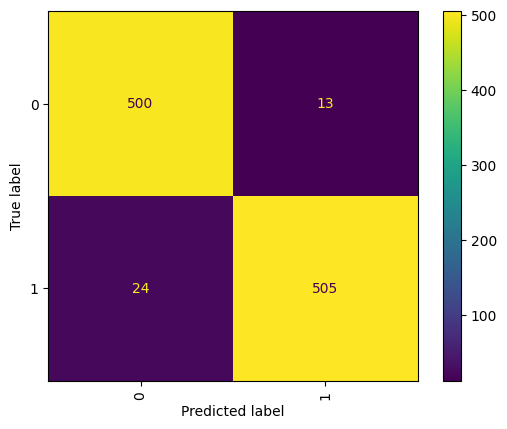

In [337]:
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

pred_y = svm_classifier.predict(test_x_scaled)

print(classification_report(test_y, pred_y, target_names=['Normal', 'Malware'], digits=4))

ConfusionMatrixDisplay.from_estimator(svm_classifier, test_x_scaled, test_y, xticks_rotation="vertical")

The SVM manages to find a good separation hyperplane, the performance is good and there is no significant difference between the f-1 scores of Malwares and Benign software. In previous iterations of this model that didn't use the outlier elimination step the number of false positives was two times higher.

In [338]:
import pickle

with open('svm_model.pkl','wb') as f:
    pickle.dump(svm_classifier,f)

The model is exported in a usable form for classification applications.

### 5.2: NN Validation

              precision    recall  f1-score   support

      Normal     0.9710    0.9786    0.9748       513
     Malware     0.9790    0.9716    0.9753       529

    accuracy                         0.9750      1042
   macro avg     0.9750    0.9751    0.9750      1042
weighted avg     0.9751    0.9750    0.9750      1042



/home/francescodm/Documents/Uni/AI/ai-project/.venv/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
/home/francescodm/Documents/Uni/AI/ai-project/.venv/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(


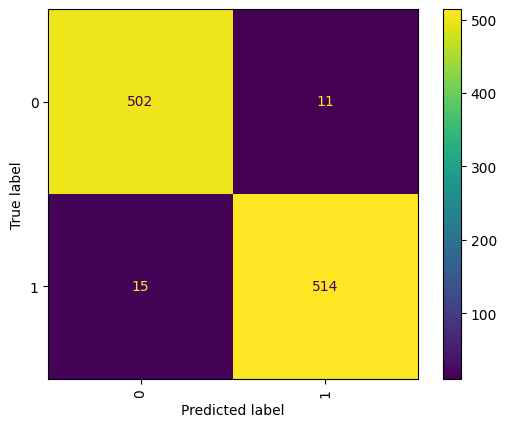

In [339]:
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

pred_y_mlp = mlp_best.predict(test_x_scaled)

print(classification_report(test_y, pred_y_mlp, target_names=['Normal', 'Malware'], digits=4))

ConfusionMatrixDisplay.from_estimator(mlp_best, test_x_scaled, test_y, xticks_rotation="vertical")

The performance of the Neural Network is good and it manages to classify samples with high accuracy

In [340]:
import pickle

with open('mlp_model.pkl','wb') as f:
    pickle.dump(mlp_best,f)

### Model comparison

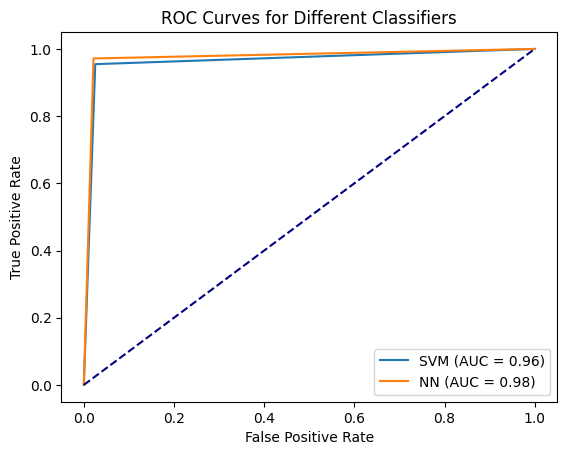

In [341]:
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split


fpr_svm, tpr_svm, _ = roc_curve(test_y, pred_y)
roc_auc = auc(fpr_svm, tpr_svm)

plt.plot(fpr_svm, tpr_svm, label=f'SVM (AUC = {roc_auc:.2f})')

fpr_mlp, tpr_mlp, _ = roc_curve(test_y, pred_y_mlp)
roc_auc = auc(fpr_mlp, tpr_mlp)
    
plt.plot(fpr_mlp, tpr_mlp, label=f'NN (AUC = {roc_auc:.2f})')

# no-discrimination line
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Different Classifiers')
plt.legend(loc='lower right')

plt.show()

In [396]:
from sklearn.model_selection import cross_val_score, StratifiedKFold

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=972)

# Model 1
scores_svm = cross_val_score(svm_classifier, test_x_scaled, test_y, cv=cv, scoring='f1_macro')
print("SVM Mean f1-score:", scores_svm.mean())

# Model 2
scores_mlp = cross_val_score(mlp_best, test_x_scaled, test_y, cv=cv, scoring='f1_macro')
print("NN Mean f1-score:", scores_mlp.mean())


SVM Mean f1-score: 0.9481321130740483
NN Mean f1-score: 0.9625442115870146


In [397]:
from scipy.stats import ttest_rel

# Perform paired t-test
t_stat, p_value = ttest_rel(scores_svm, scores_mlp)
print(f"Paired t-test: t-statistic = {t_stat}, p-value = {p_value}")


Paired t-test: t-statistic = -2.576240690157387, p-value = 0.02988032037096684


By using 10 fold cross validation on the test set we can observe similar performances between the models, with the NN narrowly beating the SVM. To further investigate this similarity in performance the t-test is performed, yielding a p-value below the threshold of 0.05, thus showing significant differences between the two.
This difference can be also appreciated in the performance of the models trained on the training set and tested on the full test set as shown in the AUC graph, the performance in this case is slightly better because of the larger amount of samples and the outlier elimination step.
This difference is due to the ability of the NN to better identify complex relationships between the features and the target class, whereas the SVM struggles a bit more in drawing a boundary as accurate as the one found by the NN.

## 6: Conclusions

The size of the dataset is too small for a task as critical as malware classification and should be increased in both quality and quantity by analyzing more and more varied malware samples, especially the notably underrepresented dll malwares. To do that sites such as malwarebazaar could be used, by using the filters provided by the service itself it would be possible and practical to assemble a higher quality and larger dataset.
I chose not to do this because of the bandwidht and space requirements that downloading various thousands malware samples would require, the code to do this is however available in the CLaMP repository [[2](#reference-section-2)], this same analysis code has been adapted to analyze single samples to test the trained models on more real-world malware examples taken from other datasets or from malware-identification sites.
The model reliably predicts the nature of these PE samples correctly.

Regarding feature selection the correlation between `filesize` and `checksum` came as a surprise since the value of a checksum is normally a hash, after checking the PE documentation and researching a bit more the checksum algorithm implemented in `ImageHelp.dll` it is apparent that this is not the method used by Microsoft, the correlation can be explained by the different approach in computing the checksum.

While the performance are satisfactory a way to improve them furhter could be to convert the packer_type variable to an ordinal after ranking the likelihood of a packer being used for malware obfuscation, this would however require extensive research and experience to do correctly.

In conclusion i see two main ways to improve performance:
-   Improve the dataset used in both size and quality by adding more varied samples, especially balancing out the near absence of infected dlls
-   Further research the packer and packer_type features to better incorporate them in the model

### 7: References

1. https://www.kaggle.com/datasets/saurabhshahane/classification-of-malwares/data <div id="reference-section-1"></div>
2. https://github.com/urwithajit9/clamp <div id="reference-section-2"></div>
3. https://en.wikipedia.org/wiki/Executable_compression <div id="reference-section-3"></div>
4. https://virustotal.github.io/yara/ <div id="reference-section-4"></div>
5. https://learn.microsoft.com/en-us/windows/win32/debug/pe-format <div id="reference-section-5"></div>
6. https://scikit-learn.org/stable/modules/svm.html <div id="reference-section-6"></div>